# Wind power forecasting
### Kirill Zakharov
##### @kirillzx
2021

In [250]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from fbprophet import Prophet

In [299]:
data = pd.read_csv('Turbine_Data.csv', parse_dates=True, index_col='Unnamed: 0')
data.index = pd.DatetimeIndex(data.index)
data = data.drop(['WTG', 'ControlBoxTemperature'], axis=1)
data = data.tz_localize(None)
names = data.columns

In [300]:
data = data.resample('D').last()

In [301]:
data.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,751.000000,747.000000,477.000000,322.000000,322.000000,322.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,750.000000,751.000000,477.000000,481.000000,750.000000,750.000000
mean,547.975725,25.499456,42.118908,10.394964,10.788067,10.788067,62.550697,56.682654,1067.073206,69.366119,68.679372,35.356337,35.747081,214.702453,72.955886,9.561828,219.548857,214.702453,5.602568
std,608.289241,3.157667,6.752566,21.996045,21.842448,21.842448,11.470003,6.096370,519.565018,21.661617,21.736743,5.757249,5.688188,93.274635,110.494651,4.671376,1820.398970,93.274635,2.442697
min,-9.624431,0.000000,0.000000,-1.216834,-0.713288,-0.713288,0.000000,26.941901,0.000000,28.311222,28.113623,0.000000,0.000000,0.000000,-20.049324,0.000000,0.000000,0.000000,0.000000
25%,65.021801,23.266351,39.477579,-0.933524,-0.421488,-0.421488,57.080139,53.363273,1029.903367,54.836054,54.038286,32.012517,32.618750,160.000000,-0.300241,9.231129,2.000000,160.000000,3.711958
50%,283.677483,25.470568,41.882642,0.704629,1.167725,1.167725,62.247553,56.037790,1036.172310,60.655950,59.813004,35.990834,35.562500,203.000000,22.190894,9.289061,2.000000,203.000000,5.206428
75%,889.198581,27.418925,45.878451,6.558314,6.742398,6.742398,68.805979,59.915685,1451.057590,79.908856,79.330703,39.003815,39.037497,302.000000,96.587541,13.003797,2.000000,302.000000,7.219951
max,1749.108400,36.739422,52.545246,90.143610,90.017830,90.017830,80.110912,68.004814,1772.362500,119.188927,118.602657,44.994124,48.063507,357.000000,350.769371,15.901775,16384.000000,357.000000,16.378908


In [302]:
data.shape

(821, 19)

In [303]:
data1 = data.dropna()
data1.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,573.203847,25.416761,42.013005,10.515879,10.907665,10.907665,62.293361,56.700665,1060.296183,70.572078,69.877763,35.199971,36.016439,239.223655,114.519022,9.498946,325.440252,239.223655,5.644639
std,630.531048,2.903306,7.682274,22.107357,21.953188,21.953188,13.007799,6.984319,544.954651,23.278161,23.351660,6.313240,6.028616,91.231200,129.547705,4.902031,2231.886290,91.231200,2.527830
min,-8.776684,19.782595,0.000000,-1.216834,-0.713288,-0.713288,0.000000,26.941901,0.000000,28.311222,28.113623,0.000000,0.000000,0.000000,-20.049324,0.000000,0.000000,0.000000,1.186479
25%,53.818275,23.168580,39.516230,-0.933524,-0.421488,-0.421488,56.498211,52.624159,1029.882529,54.295079,53.477276,32.683316,33.187264,178.000000,8.451004,9.230421,2.000000,178.000000,3.711994
50%,285.784645,25.449787,41.730931,0.679346,1.149949,1.149949,61.783442,55.778557,1032.094740,61.578786,60.785946,35.989982,35.919531,212.000000,58.337421,9.256710,2.000000,212.000000,5.184765
75%,1008.859506,26.811525,46.953679,6.591127,6.907414,6.907414,70.917949,61.758276,1474.264897,83.759447,83.174300,39.003815,39.125000,338.000000,206.135518,13.217619,2.000000,338.000000,7.549920
max,1729.357190,36.739422,52.545246,90.143610,90.017830,90.017830,80.110912,68.004814,1772.362500,119.188927,118.602657,44.994124,48.063507,357.000000,350.769371,15.901775,16384.000000,357.000000,13.377500


In [304]:
data2 = data.fillna(method='bfill')
data2.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000
mean,555.192320,25.510993,41.180605,6.617734,7.007324,7.007324,61.167188,56.495092,1120.737289,75.079257,74.462329,34.157710,34.205816,212.009400,70.476284,10.047229,138.535932,212.009400,5.617267
std,613.378555,3.162893,6.239669,15.160147,15.064771,15.064771,11.152064,6.208101,644.654626,24.047739,24.115115,4.934130,5.121188,94.917998,107.822171,5.787430,1396.526742,94.917998,2.469919
min,-9.624431,0.000000,0.000000,-1.216834,-0.713288,-0.713288,0.000000,26.941901,0.000000,28.311222,28.113623,0.000000,0.000000,0.000000,-20.049324,0.000000,0.000000,0.000000,0.000000
25%,62.666211,23.323377,39.008366,1.696667,2.181644,2.181644,56.138219,52.864381,1029.709600,53.946699,53.160701,31.993125,32.312500,151.000000,-0.374627,9.226897,2.000000,151.000000,3.701516
50%,291.809621,25.535024,43.355160,3.519508,3.907145,3.907145,65.050019,57.411825,1166.587689,65.070171,64.303383,34.153065,33.744657,203.000000,21.930899,10.460003,2.000000,203.000000,5.206745
75%,910.172188,27.356967,43.355160,3.519508,3.907145,3.907145,66.219992,60.571222,1733.245167,100.516190,100.007068,37.003615,37.049746,298.000000,95.513342,15.546140,2.000000,298.000000,7.246516
max,1749.108400,36.739422,52.545246,90.143610,90.017830,90.017830,80.110912,68.004814,1772.362500,119.188927,118.602657,44.994124,48.063507,357.000000,350.769371,15.901775,16384.000000,357.000000,16.378908


In [305]:
data2.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
2017-12-31,323.347510,23.425090,43.35516,3.519508,3.907145,3.907145,66.219992,60.571222,1733.245167,100.51619,100.007068,34.153065,33.744657,302.0,65.680133,15.54614,2.0,302.0,5.484017
2018-01-01,323.347510,23.425090,43.35516,3.519508,3.907145,3.907145,66.219992,60.571222,1733.245167,100.51619,100.007068,34.153065,33.744657,302.0,65.680133,15.54614,2.0,302.0,5.484017
2018-01-02,278.661972,21.663494,43.35516,3.519508,3.907145,3.907145,66.219992,60.571222,1733.245167,100.51619,100.007068,34.153065,33.744657,295.0,56.434792,15.54614,2.0,295.0,5.210086
2018-01-03,473.315933,22.567029,43.35516,3.519508,3.907145,3.907145,66.219992,60.571222,1733.245167,100.51619,100.007068,34.153065,33.744657,295.0,95.513342,15.54614,2.0,295.0,6.036007
2018-01-04,26.811469,21.293779,43.35516,3.519508,3.907145,3.907145,66.219992,60.571222,1733.245167,100.51619,100.007068,34.153065,33.744657,298.0,4.926317,15.54614,2.0,298.0,3.161165


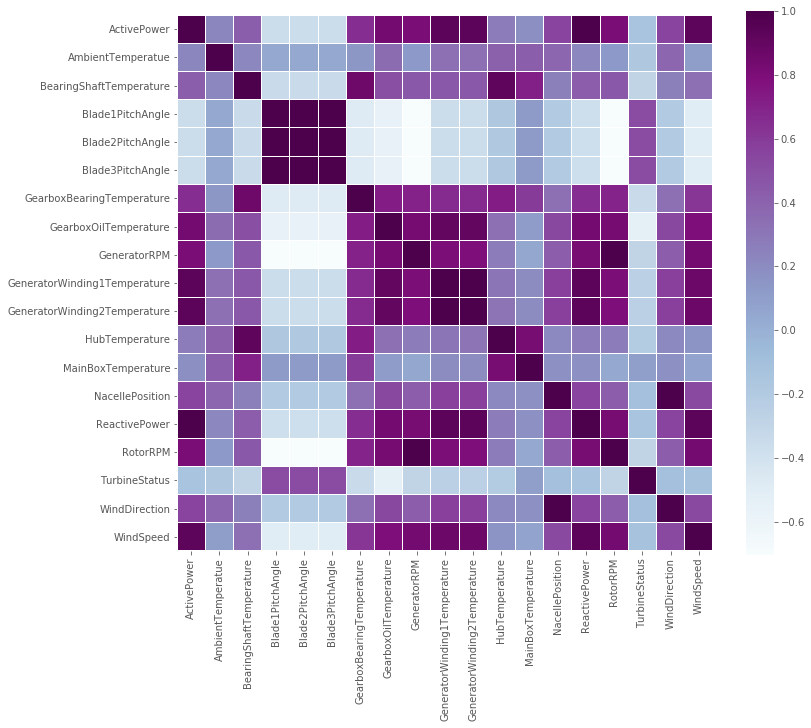

In [306]:
fig = plt.figure(figsize=(12,10))

sns.heatmap(data1.corr(), annot=False, cmap='BuPu', square=True, linewidth=0.01)
b1,t1=plt.ylim()
b1+=0.5
t1-=0.5
plt.ylim(b1, t1)
plt.show()

## Model with all features

### Linear Regression

In [307]:
X = data1.iloc[:,1:]
Y = data1.iloc[:, 0]
validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [308]:
model = LinearRegression()
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-8.30385887469841

In [309]:
model.fit(X_train, Y_train)
forecast = model.predict(X_test)

In [310]:
#r2
model.score(X_train, Y_train)

0.9997679869401939

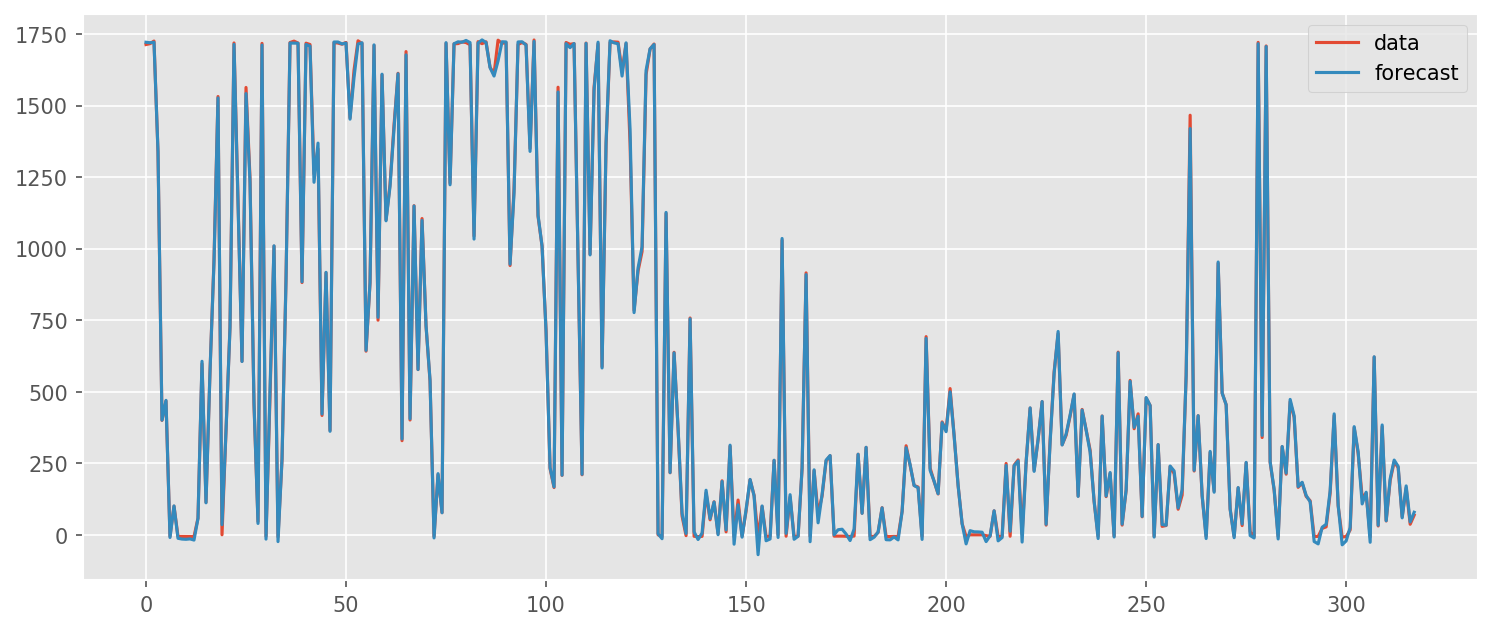

In [311]:
plt.subplots(figsize=(12, 5), dpi=150)
plt.plot(data1.iloc[:, 0].values, label='data')
plt.plot(model.predict(data1.iloc[:, 1:]), label='forecast')
plt.legend()
plt.show()

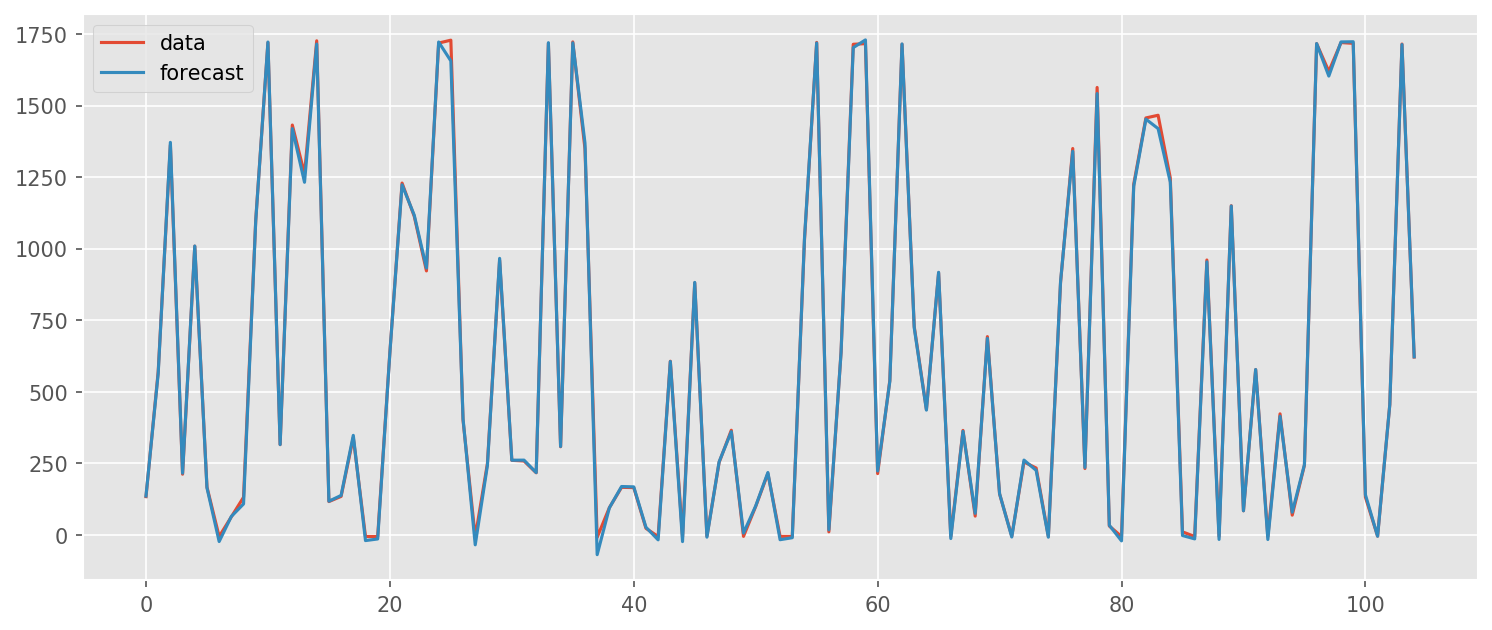

In [312]:
plt.subplots(figsize=(12, 5), dpi=150)
plt.plot(Y_test.values, label='data')
plt.plot(model.predict(X_test), label='forecast')
plt.legend()
plt.show()

### Ridge

In [313]:
model = Ridge()
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-8.051520564826372

In [314]:
model.fit(X_train, Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [315]:
#r2
model.score(X_train, Y_train)

0.9997674840214331

In [316]:
#r2
model.score(X_test, Y_test)

0.9995302237879855

In [317]:
forecast = model.predict(X_test)

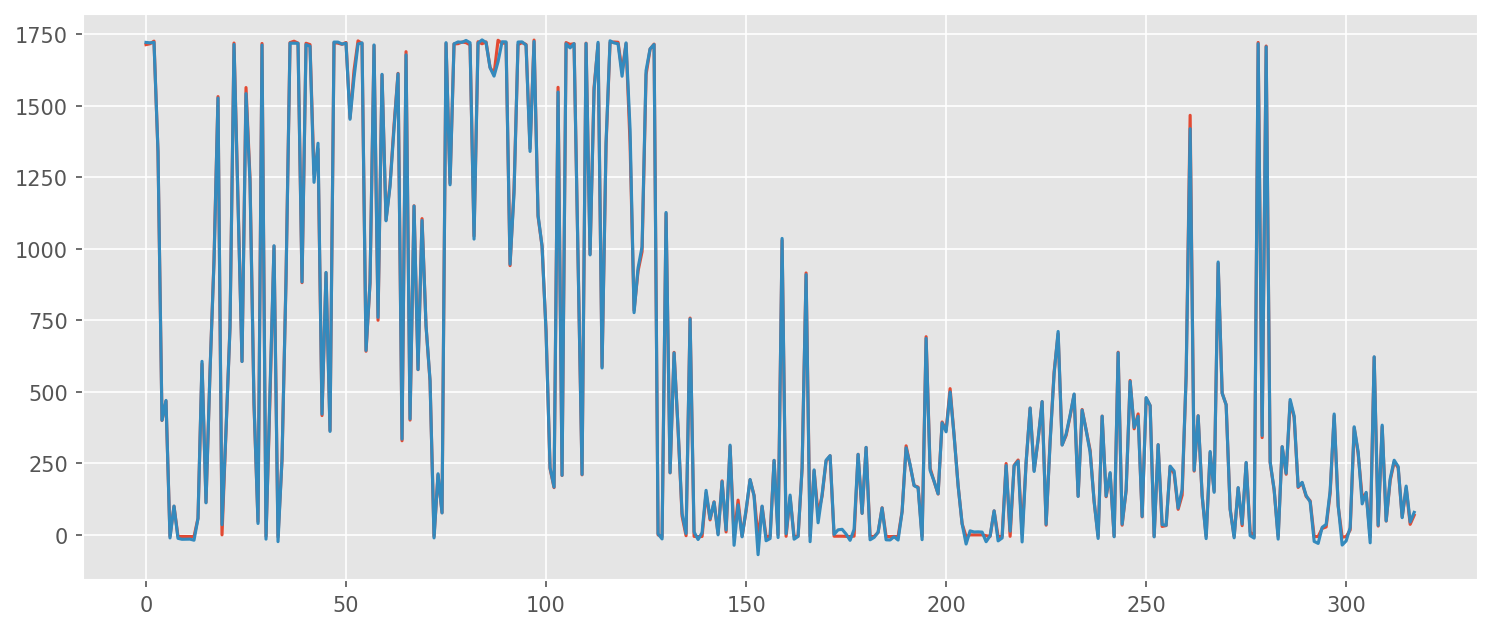

In [318]:
plt.subplots(figsize=(12, 5), dpi=150)
plt.plot(data1.iloc[:, 0].values)
plt.plot(model.predict(data1.iloc[:, 1:]))
plt.show()

## Model with selected features and droped NaN data

In [319]:
names_features = ['AmbientTemperatue','BearingShaftTemperature',\
                  'HubTemperature', 'MainBoxTemperature', 'WindSpeed']
X = data1[names_features]
Y = data1.iloc[:, 0]
validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [327]:
# model = LinearRegression(normalize=True)
# model = Ridge()
model = Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-57.40508219475343

In [328]:
model.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('GBM',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='ls', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                        

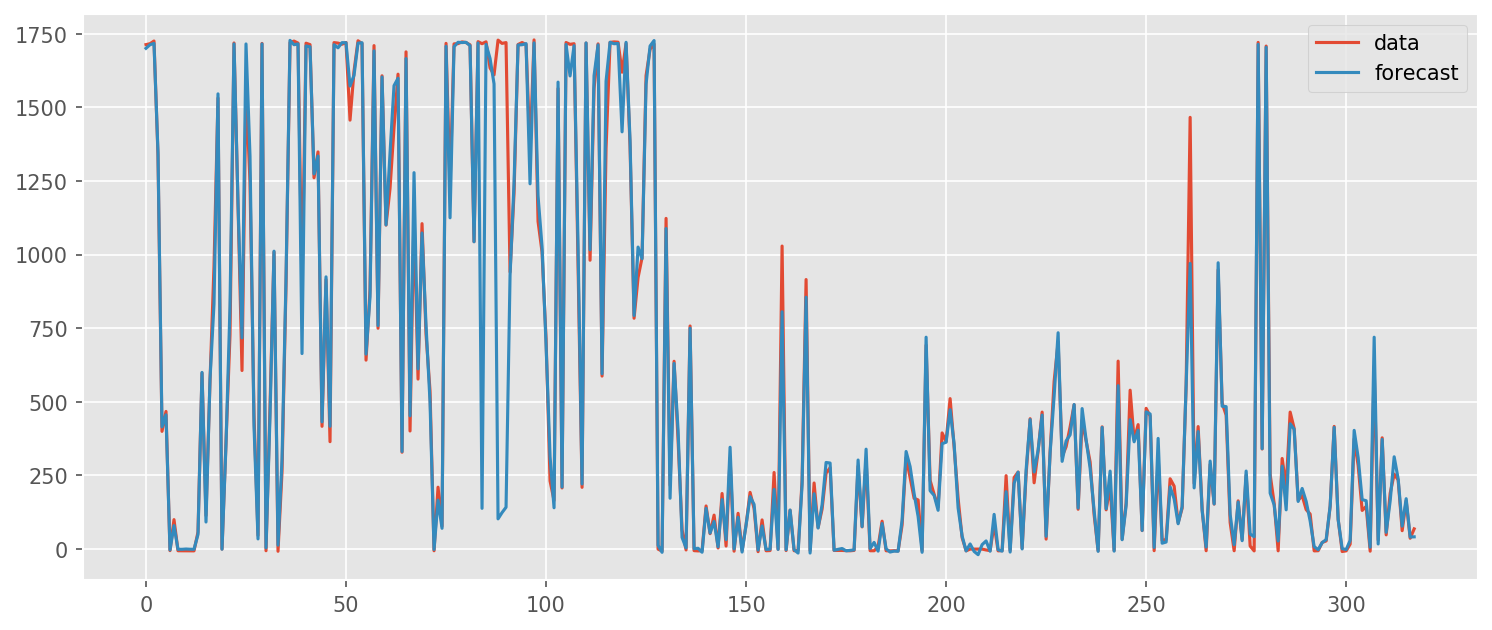

In [329]:
plt.subplots(figsize=(12, 5), dpi=150)
plt.plot(data1.iloc[:, 0].values, label='data')
plt.plot(model.predict(data1[names_features]), label='forecast')
plt.legend()
plt.show()

In [330]:
def features_forecast(name, period):
    data_prophet = data1[[name]]
    data_prophet = data_prophet.reset_index()
    data_prophet.columns = ['ds', 'y']
    
    model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    model.fit(data_prophet)
    
    future = model.make_future_dataframe(periods=period, freq='D')
    forecast = model.predict(future)
    return forecast['yhat'].values[-period:]

In [334]:
forecast_values = []
period = 14
for name in names_features:
    forecast_values.append(features_forecast(name, period))

In [335]:
start = data1.index[-1] + pd.DateOffset(days=1)
end = start + pd.DateOffset(days=period-1)
forecast_df = pd.DataFrame(model.predict(np.array(forecast_values).T),\
                           index=pd.date_range(start, end), columns=['forecast'])

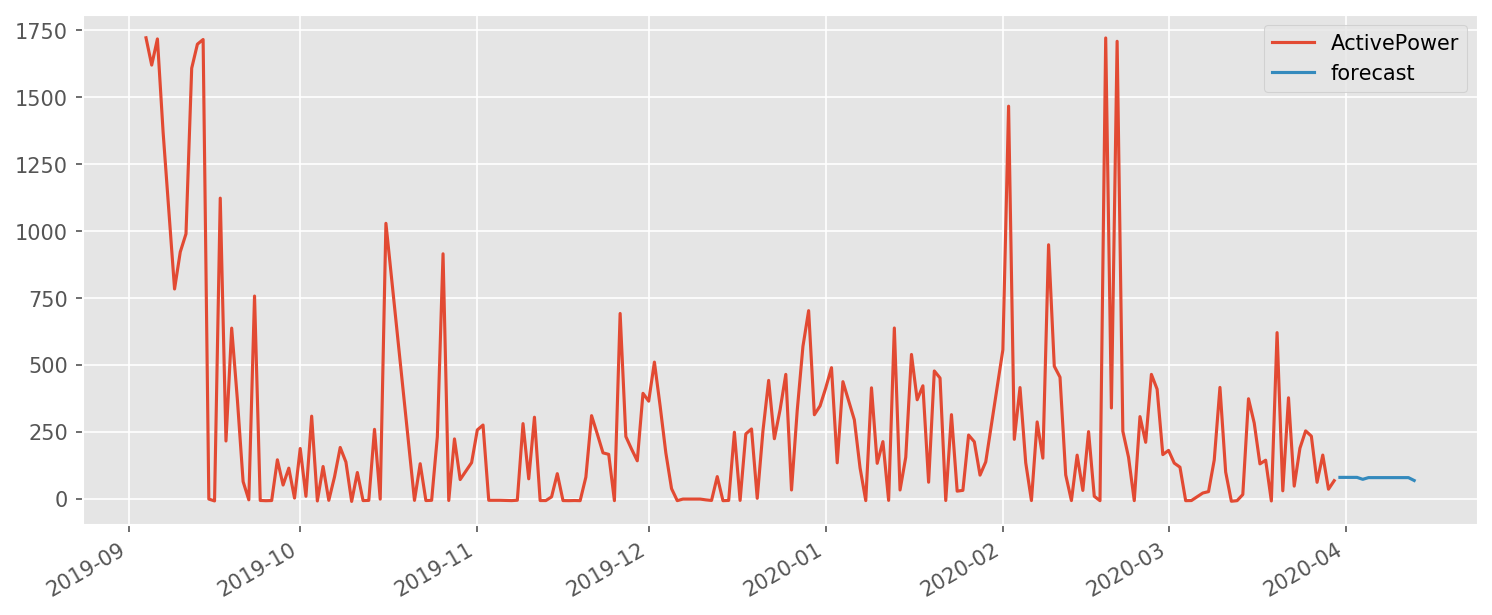

In [336]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
# plt.plot(data1.iloc[:, -14].values, label='data')
# plt.plot(model.predict(np.array(forecast_values).T), label='forecast')
data1['ActivePower'].iloc[-200:].plot()
forecast_df.plot(ax=ax)
plt.legend()
plt.show()

### Only prophet

In [218]:
data_prophet = data1[['ActivePower']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
    
model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
model.fit(data_prophet)
    
future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)

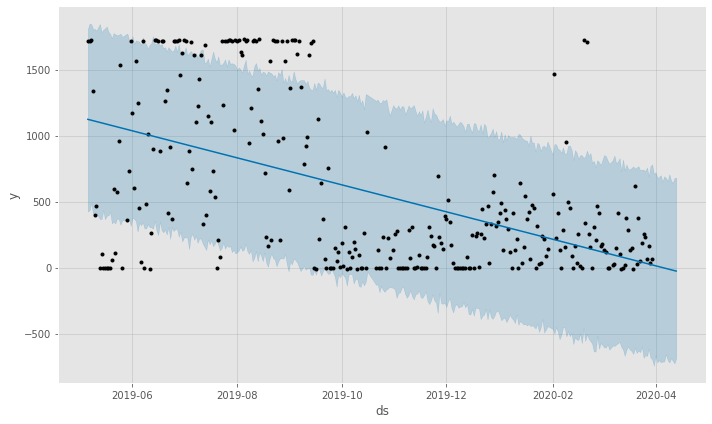

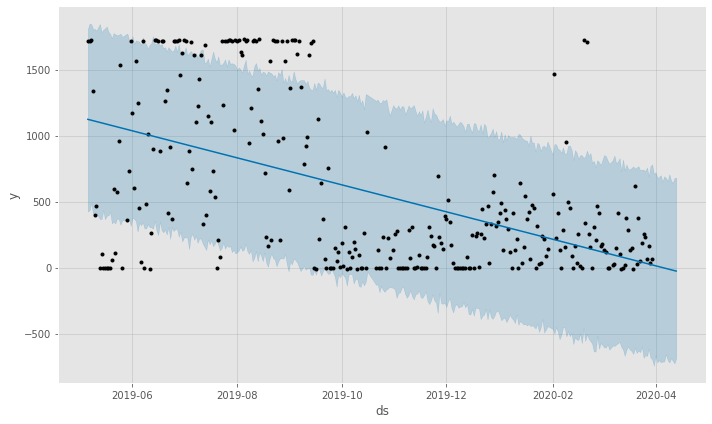

In [219]:
model.plot(forecast)

## Model with selected features and filled data 

In [259]:
names_features = ['AmbientTemperatue','BearingShaftTemperature',\
                  'HubTemperature', 'MainBoxTemperature', 'NacellePosition']
X = data2[names_features]
Y = data2.iloc[:, 0]
validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# model = LinearRegression(normalize=True)
model = Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])
# model = Ridge()

# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-258.29560869875525

In [260]:
model.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('GBM',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='ls', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                        

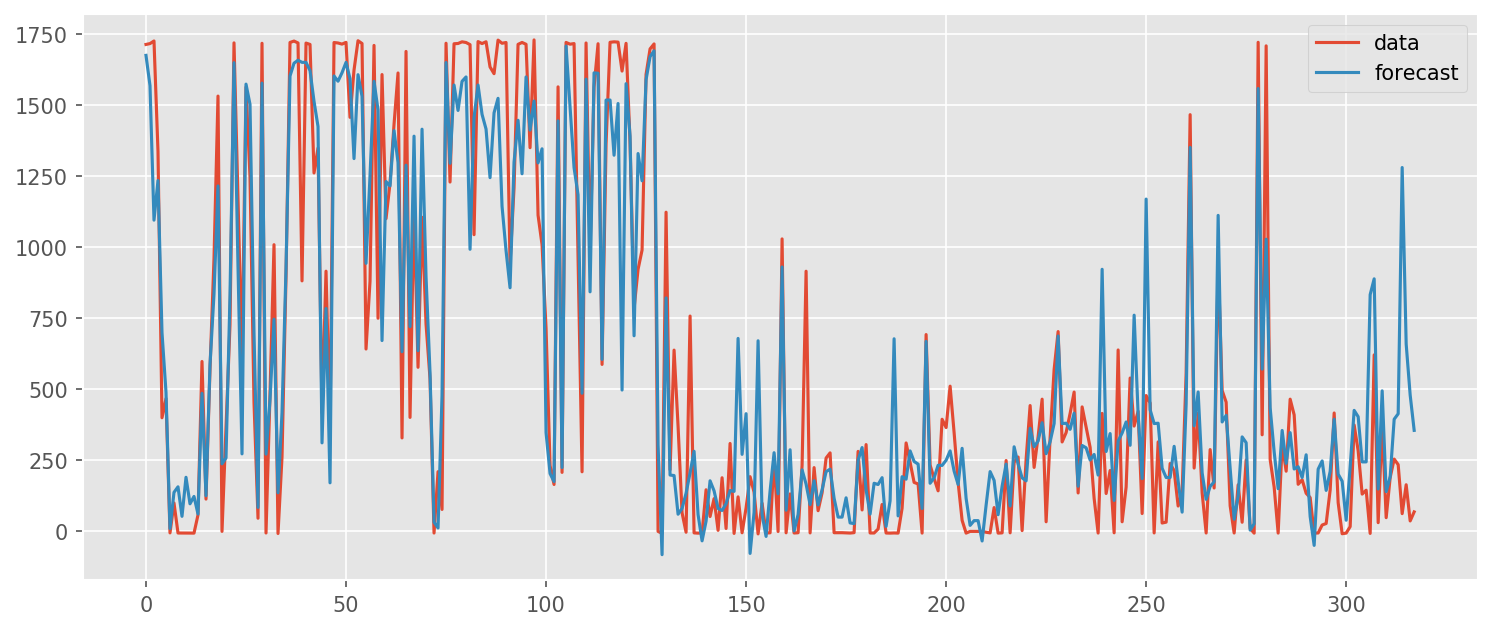

In [261]:
plt.subplots(figsize=(12, 5), dpi=150)
plt.plot(data1.iloc[:, 0].values, label='data')
plt.plot(model.predict(data1[names_features]), label='forecast')
plt.legend()
plt.show()